# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] utwórz wirtualne środowisko:
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` znajduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety
from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze środowiskiem testowym

In [2]:
# inicjalizujemy parametry testu
runs = 50
epochs = 100
recommendation_size = 10

In [3]:
# inicjalizujemy ramiona bandytów - payout każdego ramienia będzie reprezentowany przez rozkład 
# normalny - te ramiona dobrze reprezentują CTR, czyli funkcję celu o rozkładzie Bernoulliego - mamy 
# prawdopodobieństwo aktywacji (kliknięcia) `p` i stały payout po kliknięciu; możemy także przygotować
# inne typy ramion, np. z payoutem losowanym z rozkładu normalnego lub wykładniczego
good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in sample(good_arms + bad_arms, 100)}
arm_ids = list(arms.keys())

In [4]:
expected_highest_payout_per_epoch = sum(
    sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10]
)

print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.385042035068454


In [5]:
# pierwszy bandyta - wybiera losowe ramiona
class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    

    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna możliwosci każdego z ramion i wybiera najlepsze
# - przyda nam się do porównania
class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}

        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(
                arm.payout_function
            ) * arm.activation_probability
        
        self.arm_ids_sorted_by_expected_payout = [
            x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)
        ]


    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    

    def feedback(self, arm_id, payout):
        pass
    
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, żeby metodą brute-force znaleźc wartość oczekiwaną
        return sum([payout_function() for _ in range(n)]) / n

In [7]:
# tworzymy listę bandytów do przetestowania
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
# uruchamiamy test
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 640.1400000000001
random: 278.5599999999999


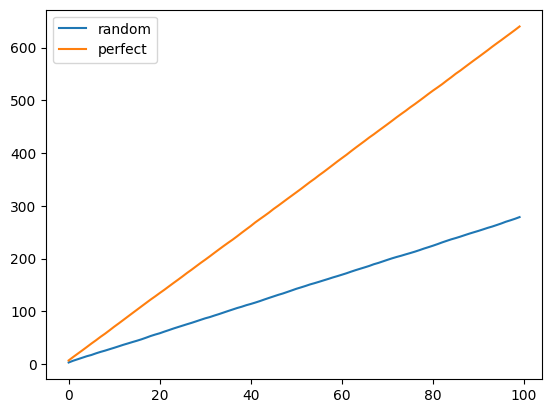

In [9]:
# wyniki sumaryczne dla wszystkich epok
runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 6.64
random: 3.18


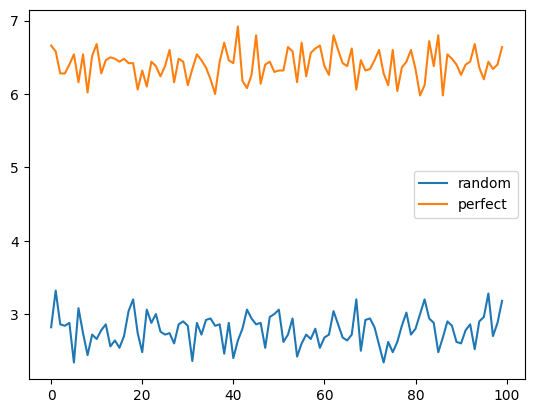

In [10]:
# wyniki per epoka
runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [11]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon
        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0. for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0. for arm_id in arm_ids}
    

    def recommend(self, size):
        sorted_arms = [x[0] for x in sorted(
            self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True
        )][:size]

        random_arms = sample(self.arm_ids, size)
        recommendation = []
        i = 0

        while len(recommendation) < size:
            rec = sorted_arms[i] if random() > self.epsilon else random_arms[i]

            if rec not in recommendation:
                recommendation.append(rec)
                self.recommended_rates[rec] += 1

            i = (i+1) % size

        return recommendation

    
    def feedback(self, arm_id, payout):
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]
        
        if payout > 0.:
            self.activation_rates[arm_id] += 1

In [12]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight
        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0. for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0. for arm_id in arm_ids}
        self.n = 0
    

    def recommend(self, size):
        payouts_per_recommendation_with_opt = {}

        for arm_id in self.payouts_per_recommendation:
            payouts_per_recommendation_with_opt[arm_id] = self.payouts_per_recommendation[arm_id]\
                + self.optimism_weight * self._optimism(arm_id)
        
        recommendation = [x[0] for x in sorted(
            payouts_per_recommendation_with_opt.items(), key=lambda x: x[1], reverse=True
        )][:size]

        for rec in recommendation:
            self.recommended_rates[rec] += 1
            
        self.n += size

        return recommendation
    

    def feedback(self, arm_id, payout):
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]
        
        if payout > 0.:
            self.activation_rates[arm_id] += 1

    
    def _optimism(self, arm_id):
        if self.recommended_rates[arm_id] == 0:
            return 1.
        
        return sqrt(2 * log(self.n) / self.recommended_rates[arm_id])

In [13]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    

    def recommend(self, size):
        distribution_values = {}

        for arm_id in self.arm_ids:
            distribution_values[arm_id] = betavariate(self.a[arm_id], self.b[arm_id])

        return [
            x[0] for x in sorted(distribution_values.items(), key=lambda x: x[1], reverse=True)
        ][:size]
    
    
    def feedback(self, arm_id, payout):
        self.a[arm_id] += payout * self.reward_multiplier
        self.b[arm_id] += max(1 - payout, 0) * self.regret_multiplier

## Część 3. - zgrubne porównanie bandytów

In [14]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

# nie wahaj się wybrać innych wartości parametrów bandytów
bandits.extend([
    EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]
])

bandits.extend([
    UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight)
    for optimism_weight in [0.01, 0.1, 1, 10]
])

bandits.extend([
    ThompsonSampling(
        'ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight
    ) for reward_weight, regret_weight in product([1, 5, 20], [1, 5, 20])
])

In [15]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_20
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_20
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_20



Aggregated results:

ts_1_5: 6.58
ts_5_1: 6.44
perfect: 6.38
ts_1_1: 6.38
ts_5_20: 6.3
ts_5_5: 6.1
ts_20_1: 6.1
ts_20_5: 5.96
egreedy_0.05: 5.94
ts_1_20: 5.88
egreedy_0.01: 5.7
egreedy_0.1: 5.46
egreedy_0.25: 5.32
ucb_1: 5.28
ts_20_20: 5.28
ucb_0.1: 3.38
ucb_0.01: 3.3
ucb_10: 3.24
random: 2.64


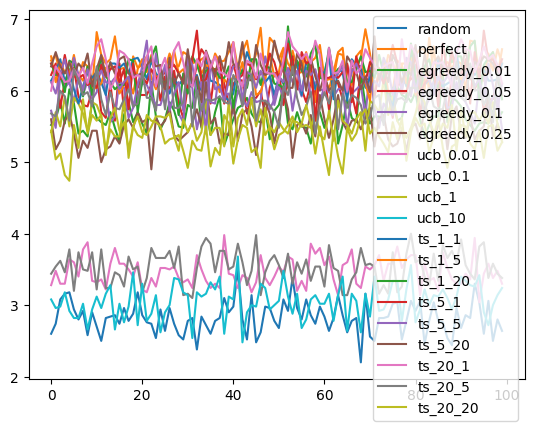

In [16]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 637.68
ts_20_1: 635.6
ts_5_20: 630.4400000000002
ts_1_5: 626.1400000000003
ts_5_1: 625.6200000000001
ts_1_20: 624.5200000000002
ts_1_1: 619.6799999999997
ts_5_5: 614.8800000000001
egreedy_0.05: 605.08
egreedy_0.1: 593.9000000000002
ts_20_5: 589.0599999999998
egreedy_0.01: 565.8400000000001
ucb_1: 556.1
egreedy_0.25: 549.1400000000002
ts_20_20: 535.2999999999997
ucb_0.1: 352.7999999999999
ucb_0.01: 346.47999999999985
ucb_10: 305.68
random: 282.3


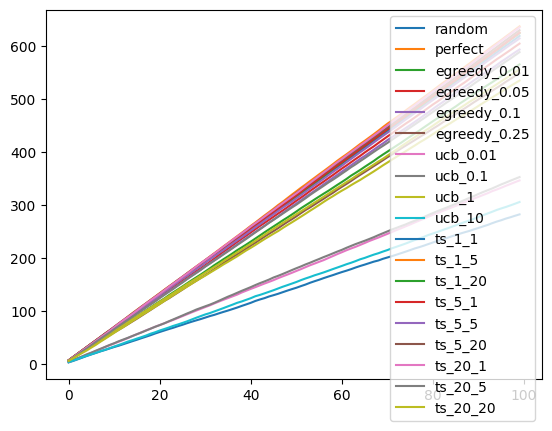

In [17]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [18]:
# obliczmy listę wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [19]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation[:k]) / float(k)

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation[:k]) / all_relevant

In [20]:
# sprawdźmy, czy działa
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]

print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(
    f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}'
)

Precision@3 for bandit ts_20_20: 1.0
Recall@3 for bandit ts_20_20: 0.3


In [21]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    print(tabulate(data, headers, tablefmt='github'))

In [22]:
# wybieramy kilku istniejących, wytrenowanych bandytów (perfect, random, po jednym e-greedy, UCB, TS)
testing_bandits = [
    bandits[0], # random
    bandits[1], # perfect
    bandits[3], # egreedy 0.05
    bandits[8], # UCB 1
    bandits[13] # TS 5,1
]

# wybieramy wartości k do porównania
k_vals = [3, 5, 10]

# bedziemy liczyć średni precision i recall dla `samples` rekomendacji
samples = 10

# miejsce na wyniki
results = []

# dla każdego bandyty - generujemy `samples` rekomendacji, liczymy precision i recall, 
# zapisujemy średnie wartości; powtarzamy dla każdego k
# uwaga! przed przeprowadzeniem porównania, bandyci musza się nauczyć
# pamiętaj o uruchomieniu `runner.simulate()` w poprzedniej części
for testing_bandit in testing_bandits:
    for k_val in k_vals:
        precisions = [0] * samples
        recalls = [0] * samples

        for i in range(samples):
            recommendation_ids = testing_bandit.recommend(samples)
            recommendation = [arms[arm_id] for arm_id in recommendation_ids]
            precisions[i] = precision_at_k(recommendation, k_val)
            recalls[i] = recall_at_k(recommendation, k_val, all_relevant)
        
        results.append(TestEntry(
            testing_bandit.bandit_id, k_val, sum(precisions) / samples, sum(recalls) / samples
        ))

print_test_results(results)

| bandit       |   k |   precision@k |   recall@k |
|--------------|-----|---------------|------------|
| egreedy_0.05 |   3 |      0.966667 |       0.29 |
| egreedy_0.05 |   5 |      1        |       0.5  |
| egreedy_0.05 |  10 |      0.94     |       0.94 |
| perfect      |   3 |      1        |       0.3  |
| perfect      |   5 |      1        |       0.5  |
| perfect      |  10 |      1        |       1    |
| random       |   3 |      0.1      |       0.03 |
| random       |   5 |      0.06     |       0.03 |
| random       |  10 |      0.09     |       0.09 |
| ts_5_1       |   3 |      1        |       0.3  |
| ts_5_1       |   5 |      1        |       0.5  |
| ts_5_1       |  10 |      1        |       1    |
| ucb_1        |   3 |      1        |       0.3  |
| ucb_1        |   5 |      1        |       0.5  |
| ucb_1        |  10 |      0.92     |       0.92 |
